# Airplane Engine Detection
Detect Airplane Engine from FDM Data. Engine are identified using these columns:
1. `engcycle_x_hr`: If exist `engcycle_4_hr` column value, then airplane has 4 engine.
2. `ctrlcolumn_pos_capt`: If exist `ctrlcolumn_pos_capt` column value, then airplane engine is B747, otherwise it's A380.

### Import

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns

### Define File

In [14]:
base_path = '../dataset/database_local'
# base_path = '../dataset/database'

In [15]:
# Input
flight_runway_file = f'{base_path}/04_flights_with_runway.csv'
landing_runway_file = f'{base_path}/04_landing_count_detail.csv'

# Output
output_file = f'{base_path}/05_flight_engine.csv'

### Read Data

#### 1. Read Flight Runway Data 

In [16]:
flight_runway = pd.read_csv(flight_runway_file)
flight_runway.head()

,fname,tail_id,dep_airport,dep_rwy,arr_airport,arr_rwy,fsize_mb,fullpath
0,686200104121532.csv,tail_686_1,BHM,36,DTW,09R,68.39,../dataset/fdm/tail_686_1/686200104121532.csv
1,686200104121245.csv,tail_686_1,DTW,03L,BHM,24,61.52,../dataset/fdm/tail_686_1/686200104121245.csv
2,686200104121825.csv,tail_686_2,DTW,03L,LEX,22,40.71,../dataset/fdm/tail_686_2/686200104121825.csv
3,686200104130429.csv,tail_686_2,LEX,22,DTW,09R,42.63,../dataset/fdm/tail_686_2/686200104130429.csv
4,686200104130652.csv,tail_687_1,DTW,09R,OKC,31,95.92,../dataset/fdm/tail_687_1/686200104130652.csv


#### 2. Read Landing Runway Count

In [17]:
landing_runway_count = pd.read_csv(landing_runway_file)
landing_runway_count.head()

,iata_code,runway_ident,flight_count,icao_code,type,name,latitude_rad,longitude_rad,elevation_ft,scheduled_service
0,DTW,DTW.09R,2,KDTW,large_airport,Detroit Metropolitan Wayne County Airport,0.736745,-1.454791,645.0,yes
1,OKC,OKC.31,1,KOKC,large_airport,Will Rogers World Airport,0.617726,-1.703454,1295.0,yes
2,LEX,LEX.22,1,KLEX,large_airport,Blue Grass Airport,0.663862,-1.476652,979.0,yes
3,BHM,BHM.24,1,KBHM,large_airport,Birmingham-Shuttlesworth International Airport,0.585783,-1.514134,650.0,yes


## Transform Data 

#### 1. Append Full Runway Id Column

In [18]:
arrival_runway_id = flight_runway['arr_airport'] + '.' + flight_runway['arr_rwy']
arrival_runway_id.head()

0    DTW.09R
1     BHM.24
2     LEX.22
3    DTW.09R
4     OKC.31
dtype: object

In [19]:
flight_runway['arr_rwy_id'] = arrival_runway_id
flight_runway.head()

,fname,tail_id,dep_airport,dep_rwy,arr_airport,arr_rwy,fsize_mb,fullpath,arr_rwy_id
0,686200104121532.csv,tail_686_1,BHM,36,DTW,09R,68.39,../dataset/fdm/tail_686_1/686200104121532.csv,DTW.09R
1,686200104121245.csv,tail_686_1,DTW,03L,BHM,24,61.52,../dataset/fdm/tail_686_1/686200104121245.csv,BHM.24
2,686200104121825.csv,tail_686_2,DTW,03L,LEX,22,40.71,../dataset/fdm/tail_686_2/686200104121825.csv,LEX.22
3,686200104130429.csv,tail_686_2,LEX,22,DTW,09R,42.63,../dataset/fdm/tail_686_2/686200104130429.csv,DTW.09R
4,686200104130652.csv,tail_687_1,DTW,09R,OKC,31,95.92,../dataset/fdm/tail_687_1/686200104130652.csv,OKC.31


#### 2. Select Flight with Selected Runway Id

In [20]:
# Choose flight's landing runway to detect airplane engine
# landing_runways = ['MSP.30R']
landing_runways = ['MSP.30R', 'DTW.09R']

In [21]:
selected_flight = flight_runway[flight_runway['arr_rwy_id'].isin(landing_runways)]
display(selected_flight.head())
selected_flight.shape

,fname,tail_id,dep_airport,dep_rwy,arr_airport,arr_rwy,fsize_mb,fullpath,arr_rwy_id
0,686200104121532.csv,tail_686_1,BHM,36,DTW,09R,68.39,../dataset/fdm/tail_686_1/686200104121532.csv,DTW.09R
3,686200104130429.csv,tail_686_2,LEX,22,DTW,09R,42.63,../dataset/fdm/tail_686_2/686200104130429.csv,DTW.09R


(2, 9)

#### 3. Create Helper Function to Detect Engine

../dataset/fdm/tail_686_2/686200104130429.csv
B747


,n11_rpm,n12_rpm,n13_rpm,n14_rpm,n21_rpm,n22_rpm,n23_rpm,n24_rpm,ctrlcolumn_pos_capt,ctrlcolumn_pos_fo,eng_1_hr,eng_2_hr,eng_3_hr,eng_4_hr
0,1.0,1.75,1.75,0.9375,0.0,0.0,0.0,0.0,2828.0,1895.0,8867.0,6372.0,6372.0,8531.0
64,1.0,1.75,1.75,0.9375,0.0,0.0,0.0,0.0,2829.0,1896.0,8867.0,6372.0,6372.0,8531.0
128,1.0,1.75,1.75,0.9375,0.0,0.0,0.0,0.0,2828.0,1896.0,8867.0,6372.0,6372.0,8531.0
192,1.0,1.75,1.75,0.9375,0.0,0.0,0.0,0.0,2829.0,1896.0,8867.0,6372.0,6372.0,8531.0
256,1.0,1.75,1.75,0.9375,0.0,0.0,0.0,0.0,2829.0,1896.0,8867.0,6372.0,6372.0,8531.0


<AxesSubplot:ylabel='ctrlcolumn_pos_capt'>

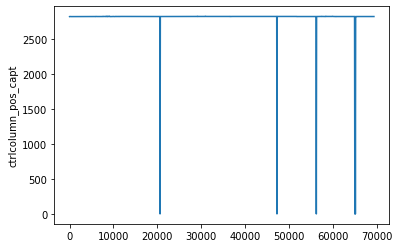

In [22]:
# For debugging function
fpath = selected_flight.sample(1).fullpath.iloc[0]
print(fpath)
fdm_df = pd.read_csv(fpath)

engine = None
if fdm_df['engcycle_4_hr'].sum() > 0:
    n_engine = 4
    if fdm_df['ctrlcolumn_pos_capt'].sum() > 0:
        engine = 'B747'
    else:
        engine = 'A380'
print(engine)
        
select_col = ['n11_rpm', 'n12_rpm', 'n13_rpm', 'n14_rpm', 'n21_rpm', 'n22_rpm', 'n23_rpm', \
              'n24_rpm', 'ctrlcolumn_pos_capt', 'ctrlcolumn_pos_fo', 'eng_1_hr', 'eng_2_hr',\
              'eng_3_hr', 'eng_4_hr']
test_df = fdm_df[select_col].dropna()
display(test_df.head())
sns.lineplot(data=test_df.ctrlcolumn_pos_capt)

#### Main Function

In [23]:
def identify_engine(filepath):
    sum_pos_fo_treshold = 0.3 * pow(10, 7)
    sum_pos_capt_treshold = 0.3 * pow(10, 7)
    
    fdm_df = pd.read_csv(filepath)
    engine = None
    if fdm_df['engcycle_4_hr'].sum() > 0:
        n_engine = 4
        if fdm_df['ctrlcolumn_pos_capt'].sum() > sum_pos_capt_treshold \
        and fdm_df['ctrlcolumn_pos_fo'].sum() > sum_pos_fo_treshold:
            engine = 'B747'
        else:
            engine = 'A380'
    print(f'{filepath}: {engine}')
    return engine

In [24]:
identify_engine(fpath)

../dataset/fdm/tail_686_2/686200104130429.csv: B747


'B747'

#### 4. Determine Engine

In [25]:
engines = flight_runway.sample(5).fullpath.map(identify_engine)
engines

../dataset/fdm/tail_686_1/686200104121532.csv: B747
../dataset/fdm/tail_687_1/686200104130652.csv: B747
../dataset/fdm/tail_686_2/686200104130429.csv: B747
../dataset/fdm/tail_686_2/686200104121825.csv: B747
../dataset/fdm/tail_686_1/686200104121245.csv: B747


0    B747
4    B747
3    B747
2    B747
1    B747
Name: fullpath, dtype: object

In [43]:
flight_engine = flight_runway[['fname']].copy()
flight_engine['engine'] = engines
flight_engine.to_csv(output_file, index=False)
flight_engine

,fname,engine
0,686200104121532.csv,B747
1,686200104121245.csv,B747
2,686200104121825.csv,B747
3,686200104130429.csv,B747
4,686200104130652.csv,B747


# Disclaimer
To shorten time, results are generated using multiprocessing by running `05_engine_detection.py` script.

#### Check Result

In [44]:
flight_engine = pd.read_csv(output_file)
flight_engine.head()

,fname,engine
0,686200104121532.csv,B747
1,686200104121245.csv,B747
2,686200104121825.csv,B747
3,686200104130429.csv,B747
4,686200104130652.csv,B747


In [45]:
flight_engine.engine.value_counts()

B747    5
Name: engine, dtype: int64

#### Get Engine for MSP30

In [72]:
flight_msp30 = flight_runway[flight_runway['arr_rwy_id'] == 'MSP.30R']
select_cols = ['fname', 'arr_rwy_id']
flight_msp30_engine = flight_msp30[select_cols].join(flight_engine.set_index('fname'), 
                                                     on='fname',
                                                     how='left')
flight_msp30_engine

,fname,arr_rwy_id,engine


In [73]:
flight_msp30_engine.engine.value_counts()

Series([], Name: engine, dtype: int64)